# Speech Understanding
## Robust Automatic Speech Recognition in Noisy Environment with Lip-Reading Assistance
### Akansha Gautam    (M23CSA506)
### Anchit Mulye      (M23CSA507)

# Import libraries

In [34]:
import numpy as np
import pandas as pd
from transformers import SpeechT5Processor, SpeechT5ForSpeechToText
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from evaluate import load
import pickle
from datasets import Dataset
import re
import torch
import os
import matplotlib.pyplot as plt
from IPython.display import Audio
import pysrt
import librosa
import librosa.display
import seaborn as sns

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)

# Set Device

In [2]:
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


# Load AV Speech dataset

In [3]:
avspeech_train_path = '/Users/akanshagautam/Documents/MTech/Speech Understanding/Project/dataset/avspeech/avspeech_train.csv'
avspeech_test_path = '/Users/akanshagautam/Documents/MTech/Speech Understanding/Project/dataset/avspeech/avspeech_test.csv'
names = ["youtube_id", "start_segment", "end_segment", "x_coordinate", "y_coordinate"]

avspeech_train_df = pd.read_csv(avspeech_train_path, names=names)
avspeech_test_df = pd.read_csv(avspeech_test_path, names=names)

print(f"AVSpeech Train Dataset Shape: {avspeech_train_df.shape}")
print(f"AVSpeech Test Dataset Shape: {avspeech_test_df.shape}")

avspeech_train_df.head(2)

AVSpeech Train Dataset Shape: (2621845, 5)
AVSpeech Test Dataset Shape: (183273, 5)


,youtube_id,start_segment,end_segment,x_coordinate,y_coordinate
0,CJoOwXcjhds,233.266,239.367000,0.780469,0.670833
1,AvWWVOgaMlk,90.000,93.566667,0.586719,0.311111


In [4]:
BASE_DIR = '/Users/akanshagautam/Documents/MTech/Speech Understanding/Project/dataset/avspeech/train'
temp = []

for folder in os.listdir(BASE_DIR):
    folder_path = os.path.join(BASE_DIR, folder)
    if os.path.isdir(folder_path):
        wav_path = ""
        text_path = ""
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                wav_path = os.path.join(folder_path, file)
            if file.endswith(".srt"):
                text_path = os.path.join(folder_path, file)
        temp.append({
            "youtube_id": folder,
            "wav_path": wav_path,
            "text_path": text_path
        })

wav_df = pd.DataFrame(temp)
print(f"Total wav files:", wav_df.shape[0])

given_avspeech_df = pd.merge(avspeech_train_df, wav_df, on="youtube_id", how="inner")
print(f"Final Dataset Shape: {given_avspeech_df.shape}")

given_avspeech_df.head(3)

Total wav files: 99
Final Dataset Shape: (1481, 7)


,youtube_id,start_segment,end_segment,x_coordinate,y_coordinate,wav_path,text_path
0,-A9gdf3j2xo,295.165000,298.165000,0.507812,0.233333,/Users/akanshagautam/Documents/MTech/Speech Understanding/Project/dataset/avspeech/train/-A9gdf3j2xo/-A9gdf3j2xo_audio.wav,/Users/akanshagautam/Documents/MTech/Speech Understanding/Project/dataset/avspeech/train/-A9gdf3j2xo/-A9gdf3j2xo.en.srt
1,QoQF8N5ZsQA,240.006433,244.961389,0.450781,0.358333,/Users/akanshagautam/Documents/MTech/Speech Understanding/Project/dataset/avspeech/train/QoQF8N5ZsQA/QoQF8N5ZsQA_audio.wav,/Users/akanshagautam/Documents/MTech/Speech Understanding/Project/dataset/avspeech/train/QoQF8N5ZsQA/QoQF8N5ZsQA.en.srt
2,sujFCXbYkMo,30.000000,34.466667,0.528906,0.477778,/Users/akanshagautam/Documents/MTech/Speech Understanding/Project/dataset/avspeech/train/sujFCXbYkMo/sujFCXbYkMo_audio.wav,/Users/akanshagautam/Documents/MTech/Speech Understanding/Project/dataset/avspeech/train/sujFCXbYkMo/sujFCXbYkMo.en.srt


# Exploratory Data Analysis

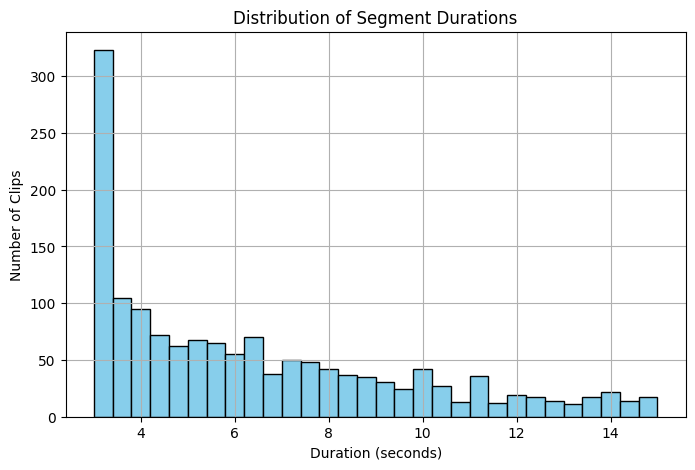

In [5]:
# Distribution of Segment Durations
given_avspeech_df['duration'] = given_avspeech_df['end_segment'] - given_avspeech_df['start_segment']

plt.figure(figsize=(8, 5))
plt.hist(given_avspeech_df['duration'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Segment Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Clips")
plt.grid(True)
plt.show()

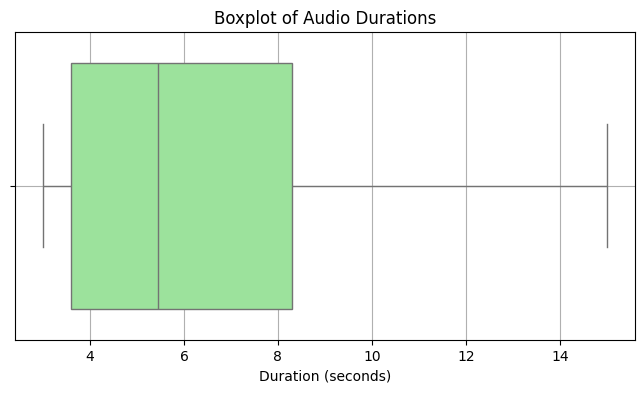

In [6]:
# Boxplot of Audio Durations
plt.figure(figsize=(8, 4))
sns.boxplot(x=given_avspeech_df['duration'], color='lightgreen')
plt.title("Boxplot of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.grid(True)
plt.show()

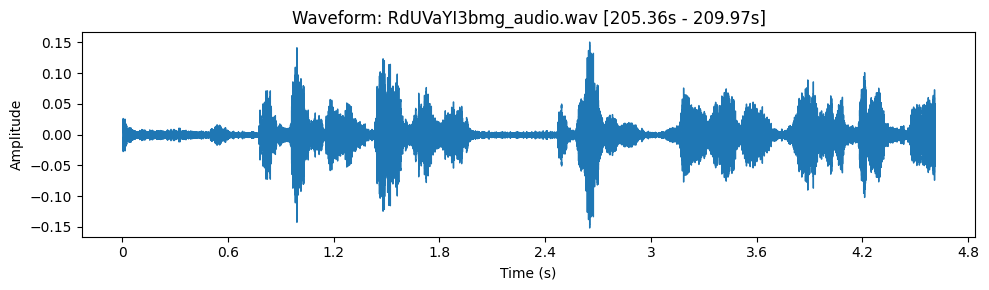

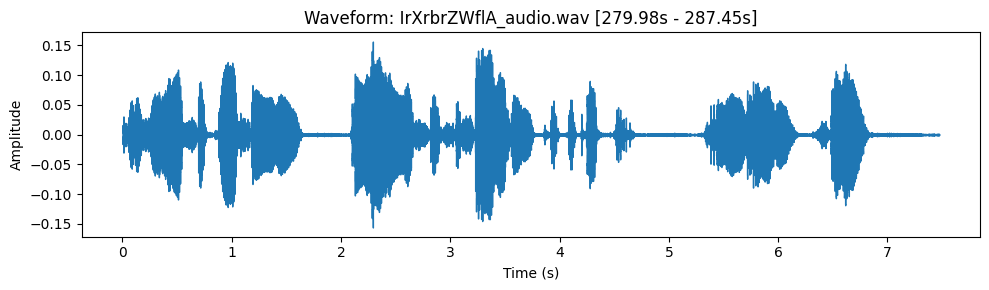

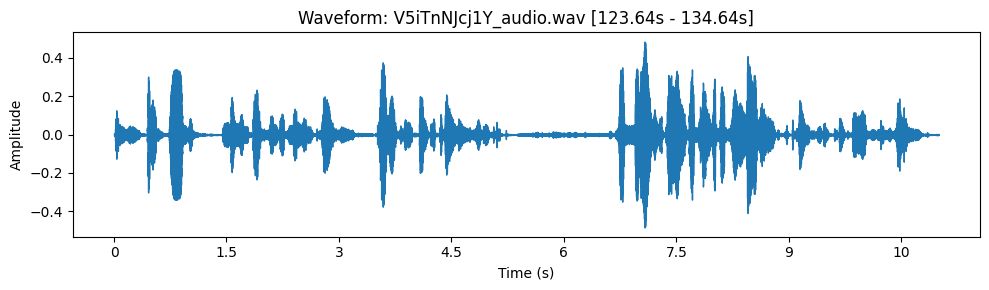

In [7]:
# waveform of sample audio files
sample_rows = given_avspeech_df.dropna(subset=['wav_path']).sample(3, random_state=42)

for _, row in sample_rows.iterrows():
    wav_path = row['wav_path']
    start_time = row['start_segment']
    end_time = row['end_segment']
    duration = end_time - start_time

    y, sr = librosa.load(wav_path, sr=None, offset=start_time, duration=duration)

    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {os.path.basename(wav_path)} [{start_time:.2f}s - {end_time:.2f}s]")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Pre-process data based on start_segment and end_segment and load the MFCC features

In [8]:
NUM_MFCC_COEFFICIENTS = 13
HOP_LENGTH = 512
FRAME_LENGTH = 2048
DURATION = 5

In [9]:
given_avspeech_df.head(1)

,youtube_id,start_segment,end_segment,x_coordinate,y_coordinate,wav_path,text_path,duration
0,-A9gdf3j2xo,295.165,298.165,0.507812,0.233333,/Users/akanshagautam/Documents/MTech/Speech Understanding/Project/dataset/avspeech/train/-A9gdf3j2xo/-A9gdf3j2xo_audio.wav,/Users/akanshagautam/Documents/MTech/Speech Understanding/Project/dataset/avspeech/train/-A9gdf3j2xo/-A9gdf3j2xo.en.srt,3.0


In [10]:
def extract_mfcc_from_segment(audio_path, start_segment, end_segment, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH, 
                              n_mfcc=NUM_MFCC_COEFFICIENTS, duration=DURATION):
    
    if len(audio_path) == 0 or audio_path is None:
        return None

    duration = end_segment - start_segment
    y, sr = librosa.load(audio_path, offset=start_segment, duration=duration, sr=16000)

    if y.size == 0:
        print(f"Empty audio file found: {audio_path}")
        return None
    
    if len(y) < frame_length:
        pad_length = frame_length - len(y)
        y = np.pad(y, (0, pad_length), mode='constant')

    y = librosa.util.normalize(y)
    y = librosa.effects.preemphasis(y)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=hop_length)
    return y, sr, mfcc

def clean_caption_text(text):
    text = re.sub(r'\[[^\]]*\]', '', text)
    text = text.replace('\\', '')
    text = re.sub(r'\s+', ' ', text)
    text = text.lower().strip()
    return text

def extract_text_from_segment(srt_path, start_time, end_time):
    if not os.path.exists(srt_path):
        return None
    try:
        subs = pysrt.open(srt_path)
        trimmed_lines = set()
        for sub in subs:
            sub_start = sub.start.ordinal / 1000
            sub_end = sub.end.ordinal / 1000
            if sub_end < start_time:
                continue
            if sub_start > end_time:
                break
            cleaned = clean_caption_text(sub.text.strip())
            if cleaned:
                trimmed_lines.add(cleaned)
        return ' '.join(sorted(trimmed_lines)) if trimmed_lines else None
    except Exception as e:
        print(f"Error processing {srt_path}: {e}")
        return None

processed_data = []
label_counter = {}
for index, row in given_avspeech_df.iterrows():
    start_segment = row['start_segment']
    end_segment = row['end_segment']
    wav_path = row['wav_path']
    text_path = row['text_path']

    mfcc_result = extract_mfcc_from_segment(wav_path, start_segment, end_segment)
    text_result = extract_text_from_segment(text_path, start_segment, end_segment)
    
    if mfcc_result is None:
        continue

    waveform, sampling_rate, mfcc = mfcc_result

    processed_data.append({
        "youtube_id": row['youtube_id'],
        "start_segment": start_segment,
        "end_segment": end_segment,
        "x_coordinate": row['x_coordinate'],
        "y_coordinate": row['y_coordinate'],
        "wav_path": wav_path,
        "text_path": row['text_path'],
        "trimmed_text": text_result,
        "duration": row['duration'],
        "waveform": waveform,
        "sampling_rate": sampling_rate,
        "mfcc": mfcc
    })

processed_df = pd.DataFrame(processed_data)
print(f"Features Dataframe Shape: {processed_df.shape}")

print("\nSample pre-processed data:")
print(f"Cleaned text: {processed_df.iloc[5]['trimmed_text']}")

y = processed_df.iloc[5]['waveform']
sr = processed_df.iloc[5]['sampling_rate']
Audio(y, rate=sr)

Features Dataframe Shape: (1481, 12)

Sample pre-processed data:
Cleaned text: and so at the center here they figured and so at the center here they figured out um that if you want to get close to back in the historic whaling days they back in the historic whaling days they would attach kegs to the to the harpoon line and that would slow down the whale line and that would slow down the whale and so at the center here they figured whale and that means slowing it down back in the historic whaling days they would attach kegs to the to the harpoon would attach kegs to the to the harpoon line and that would slow down the whale


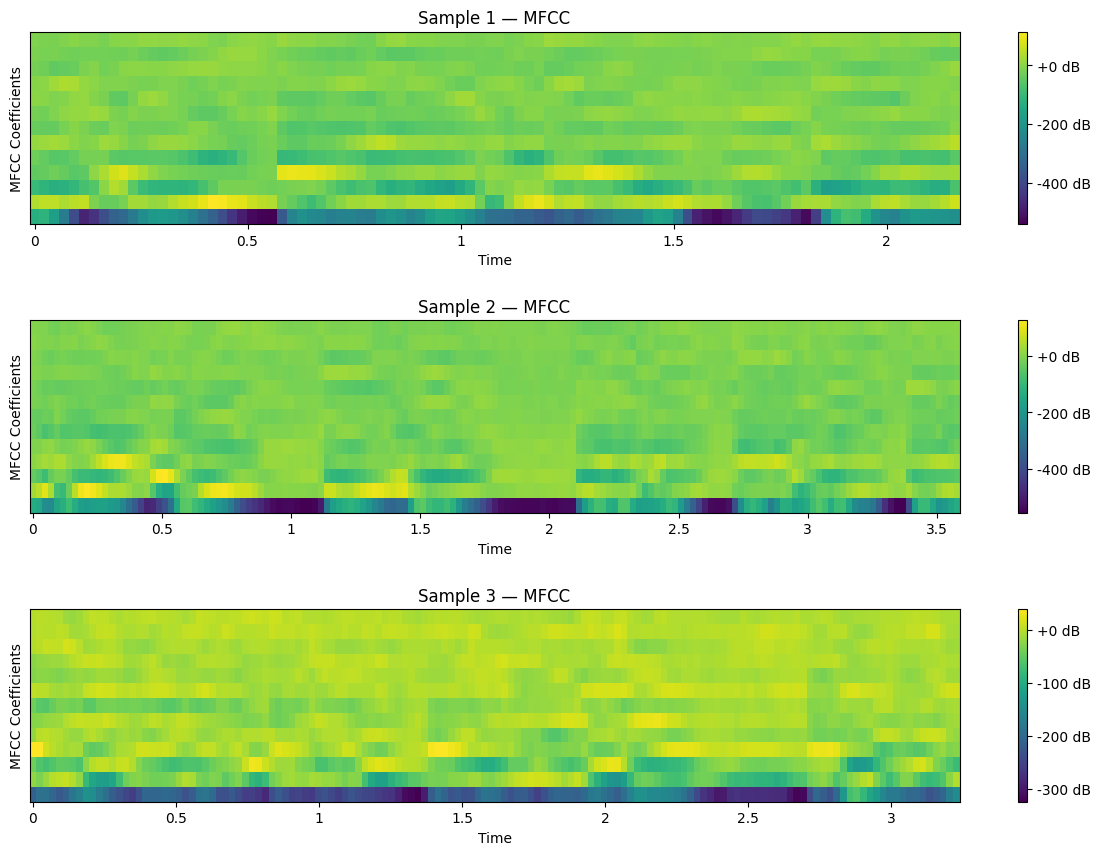

In [11]:
plt.figure(figsize=(15, 10))
index = 0
index_counter = 0

for _, row in processed_df.iterrows():

    if index_counter == 3:
        break

    mfcc = row['mfcc']

    num_frames = mfcc.shape[1]
    t = librosa.frames_to_time(range(num_frames), hop_length=HOP_LENGTH)

    plt.subplot(3, 1, index + 1)
    librosa.display.specshow(mfcc, x_coords=t, cmap='viridis', x_axis="time")
    plt.colorbar(format='%+2.0f dB')
    plt.ylabel("MFCC Coefficients")
    plt.title(f"Sample {index_counter+1} — MFCC")

    index += 1
    index_counter += 1

plt.subplots_adjust(hspace=0.5)
plt.show()


# Fine-tune the SpeechT5 Model on AVSpeech dataset

In [12]:
# Load the model and processor
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_asr")
model = SpeechT5ForSpeechToText.from_pretrained("microsoft/speecht5_asr")

SpeechT5ForSpeechToText has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of SpeechT5ForSpeechToText were not initialized from the model checkpoint at microsoft/speecht5_asr and are newly initialized: ['speecht5.encod

In [29]:
asr_df = processed_df[['waveform', 'trimmed_text']].rename(columns={'trimmed_text': 'text'})

asr_df['waveform'] = asr_df['waveform'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
asr_df = asr_df[asr_df['text'].notna() & (asr_df['text'].str.strip() != '')].reset_index(drop=True)
asr_df.head(1)

,waveform,text
0,"[0.1718801110982895, 0.13956354558467865, -0.006600528955459595, -0.015490695834159851, -0.05540849268436432, -0.0018739104270935059, -0.010853797197341919, 0.006247475743293762, -0.020723551511764526, -0.03760683536529541, -0.036177899688482285, -0.0358797162771225, -0.07291299849748611, -0.08008968085050583, -0.06763090193271637, -0.051740095019340515, -0.045960769057273865, -0.08183285593986511, -0.0932585597038269, 0.00432392954826355, 0.14506220817565918, 0.21929366886615753, 0.21421179175376892, 0.14381496608257294, 0.10727190971374512, 0.04501119256019592, -0.13709023594856262, -0.2865242660045624, -0.26409661769866943, -0.1833539605140686, -0.08907139301300049, 0.029803067445755005, 0.16513004899024963, 0.2616288959980011, 0.22745448350906372, 0.09932646155357361, 0.02016356587409973, -0.05170866847038269, -0.16435915231704712, -0.1876775026321411, -0.07815799117088318, 0.04105974733829498, 0.08605916798114777, 0.08720630407333374, 0.09545218199491501, 0.08808839321136475, 0.026448071002960205, -0.012506544589996338, -0.01683056354522705, -0.045293450355529785, -0.051899515092372894, -0.011335521936416626, 0.02648693323135376, 0.028253063559532166, -0.0038053467869758606, -0.018590934574604034, -0.016110315918922424, -0.05308529734611511, -0.08780831843614578, -0.06134422868490219, -0.04484803229570389, -0.060695722699165344, -0.06680518388748169, -0.07294648885726929, -0.048224300146102905, 0.024995148181915283, 0.12322837114334106, 0.1914493292570114, 0.151568204164505, 0.07274644076824188, 0.07230404019355774, 0.037811279296875, -0.12155771255493164, -0.2159641832113266, -0.1637343168258667, -0.086257204413414, -0.020721852779388428, 0.050234660506248474, 0.1531299203634262, 0.22164875268936157, 0.1316675841808319, 0.0047973692417144775, -0.03342905640602112, -0.090024434030056, -0.17199353873729706, -0.15464144945144653, -0.03826192021369934, 0.0804562121629715, 0.11962728947401047, 0.09021513164043427, 0.08246166259050369, 0.07305926084518433, -0.009275734424591064, -0.05205920338630676, -0.0034561455249786377, 0.019297108054161072, 0.018336951732635498, 0.02051481604576111, 0.009885251522064209, 0.008046448230743408, ...]",if someone was telling us to man up we man up you know even women are man up you know even women are man up you know even women are told to me and up i don't know i was


In [30]:
# Split the dataset
train_df, test_df = train_test_split(asr_df, test_size=0.1, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def preprocess(example):
    audio_inputs = processor(
        audio=example["waveform"],
        sampling_rate=16000,
        return_tensors="pt"
    )
    text_labels = processor.tokenizer(
        example["text"],
        return_tensors="pt"
    )

    return {
        "input_values": audio_inputs.input_values[0],
        "labels": text_labels.input_ids[0]
    }

train_dataset = train_dataset.map(preprocess, remove_columns=["waveform", "text"])
test_dataset = test_dataset.map(preprocess, remove_columns=["waveform", "text"])

print("Train Dataset Size:", len(train_dataset))
print("Test Dataset Size:", len(test_dataset))


Map: 100%|██████████| 148/148 [00:02<00:00, 50.93 examples/s]

Train Dataset Size: 1326
Test Dataset Size: 148


In [31]:
class CustomCTCCollator:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, features):
        input_values = [torch.tensor(f["input_values"]) for f in features]
        labels = [torch.tensor(f["labels"]) for f in features]

        batch = {
            "input_values": pad_sequence(input_values, batch_first=True, padding_value=0.0),
            "labels": pad_sequence(labels, batch_first=True, padding_value=self.processor.tokenizer.pad_token_id),
        }
        return batch

In [32]:
training_args = TrainingArguments(
    output_dir="/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 3/FineTunedModelOutput",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    logging_steps=20,
    save_steps=300,
    save_total_limit=2,
    fp16=False,
    bf16=False,
    no_cuda=True
)

data_collator = CustomCTCCollator(processor)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator
)

trainer.train()

/Users/akanshagautam/Documents/MTech/ml_env/lib/python3.9/site-packages/transformers/training_args.py:1595: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


Step,Training Loss
20,0.161000
40,0.184800
60,0.210900
80,0.248300
100,0.365900
120,0.354900
140,0.470100
160,0.501100
180,0.501100
200,0.512100


TrainOutput(global_step=996, training_loss=0.3716432564708603, metrics={'train_runtime': 7641.5222, 'train_samples_per_second': 0.521, 'train_steps_per_second': 0.13, 'total_flos': 5.901177773159624e+17, 'train_loss': 0.3716432564708603, 'epoch': 3.0})

# Evaluate the fine-tuned model

In [33]:
wer_metric = load("wer")

def compute_wer(model, processor, dataset):
    model.eval()
    predictions, references = [], []

    for sample in dataset:
        input_tensor = torch.tensor(sample["input_values"]).unsqueeze(0)
        with torch.no_grad():
            pred_ids = model.generate(input_tensor)
        pred_text = processor.batch_decode(pred_ids, skip_special_tokens=True)[0].lower()

        label_text = processor.tokenizer.decode(sample["labels"], skip_special_tokens=True).lower()
        predictions.append(pred_text)
        references.append(label_text)

    return wer_metric.compute(predictions=predictions, references=references)

wer = compute_wer(model, processor, test_dataset)
print(f"WER on test set: {wer:.3f}")

WER on test set: 1.067


# Save fine-tuned model

In [36]:
with open("/Users/akanshagautam/Documents/MTech/Speech Understanding/speech-understanding-project/model/fine_tuned_model_on_clean_audio.pkl", "wb") as f:
    pickle.dump(model.state_dict(), f)